In [1]:
import pandas as pd
import numpy as np

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('Sample Data.csv')

def fill_container_greedy(remaining_items, max_weight, max_volume):

    remaining_items['ratio'] = remaining_items['Volume(CBM)'] / remaining_items['Weight(kg)']
    items_sorted = remaining_items.sort_values('ratio', ascending=False)

    container_items = pd.DataFrame()
    total_weight = total_volume = 0

    for _, item in items_sorted.iterrows():
        if total_weight + item['Weight(kg)'] <= max_weight and total_volume + item['Volume(CBM)'] <= max_volume:
            container_items = container_items.append(item)
            total_weight += item['Weight(kg)']
            total_volume += item['Volume(CBM)']

    remaining_items = remaining_items.drop(container_items.index)
    return container_items, remaining_items


def allocate_items(df, specs, costs):
    allocation = {'FCL40': [], 'FCL20': [], 'LCL': []}
    remaining_items = df.copy()

    while not remaining_items.empty:
        if (remaining_items['Weight(kg)'].sum() <= specs['FCL20']['weight'] and
                remaining_items['Volume(CBM)'].sum() <= specs['FCL20']['volume']):
            container_items, remaining_items = fill_container_greedy(remaining_items, specs['FCL20']['weight'], specs['FCL20']['volume'])
            allocation['FCL20'].append(container_items)
        elif (remaining_items['Weight(kg)'].sum() > specs['FCL20']['weight'] or
              remaining_items['Volume(CBM)'].sum() > specs['FCL20']['volume']):
            container_items, remaining_items = fill_container_greedy(remaining_items, specs['FCL40']['weight'], specs['FCL40']['volume'])
            allocation['FCL40'].append(container_items)
        else:
            allocation['LCL'].append(remaining_items)
            break

    total_cost = (len(allocation['FCL40']) * costs['FCL40'] +
                  len(allocation['FCL20']) * costs['FCL20'] +
                  sum(container['Volume(CBM)'].sum() for container in allocation['LCL']) * costs['LCL'])

    return allocation, total_cost

specs = {
    'FCL40': {'weight': 30480, 'volume': 67},
    'FCL20': {'weight': 14969, 'volume': 33}
}
costs = {
    'FCL40': 5600,
    'FCL20': 3500,
    'LCL': 778
}

allocation, total_cost = allocate_items(df, specs, costs)

print("Allocated containers:")
for ctype, clist in allocation.items():
    for c in clist:
        print(f"{ctype}: IDs {c['ID'].tolist()}, Total Weight: {c['Weight(kg)'].sum()}, Total Volume: {c['Volume(CBM)'].sum()}")
print(f"Total cost: {total_cost}")


C:\Users\37605\AppData\Local\Temp\ipykernel_15704\3845512442.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  container_items = container_items.append(item)
C:\Users\37605\AppData\Local\Temp\ipykernel_15704\3845512442.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  container_items = container_items.append(item)
C:\Users\37605\AppData\Local\Temp\ipykernel_15704\3845512442.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  container_items = container_items.append(item)
C:\Users\37605\AppData\Local\Temp\ipykernel_15704\3845512442.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  container_items = container_items.append(item)


Allocated containers:
FCL40: IDs [17.0, 25.0, 15.0, 23.0, 16.0, 18.0, 22.0, 24.0, 9.0, 1.0, 11.0, 21.0, 2.0, 10.0], Total Weight: 14353.0, Total Volume: 64.4
FCL40: IDs [7.0, 20.0, 3.0, 12.0, 8.0, 19.0, 5.0, 4.0, 14.0], Total Weight: 17751.0, Total Volume: 63.4
FCL20: IDs [6.0, 13.0], Total Weight: 6252.0, Total Volume: 19.6
Total cost: 14700


C:\Users\37605\AppData\Local\Temp\ipykernel_15704\3845512442.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  container_items = container_items.append(item)
C:\Users\37605\AppData\Local\Temp\ipykernel_15704\3845512442.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  container_items = container_items.append(item)


In [329]:
transport_time_FCL = np.random.randint(19, 23) 
transport_time_LCL = np.random.randint(25, 31) 

weather_risk = np.random.choice([0, 1, 2, 3], p=[0.97, 0.01, 0.01, 0.01])

df['Allocation'] = ''
for container_type, containers in allocation.items():
    for container in containers:
        df.loc[container.index, 'Allocation'] = container_type

df['Transport Time'] = np.where(df['Allocation'] == 'FCL40', transport_time_FCL,
                       np.where(df['Allocation'] == 'FCL20', transport_time_FCL,
                       transport_time_LCL))

df['Transport Time'] += weather_risk
df['Delay Time'] = df['Transport Time'] - df['Time Requirement(Day)']
df['Delay Time'] = df['Delay Time'].clip(lower=0)
df['Delay Penalty Cost'] = df['Delay Time'] * df['Delayed Penalty(per day)']

total_delay_penalty_cost = df['Delay Penalty Cost'].sum()

for ctype, clist in allocation.items():
    for idx, c in enumerate(clist):
        print(f"{ctype} #{idx+1}: IDs {c['ID'].tolist()}, Total Weight: {c['Weight(kg)'].sum()}, Total Volume: {c['Volume(CBM)'].sum()}")

overall_cost = total_cost + total_delay_penalty_cost

print(f"Total container cost: ${total_cost}.00")
print(f"Total delay penalty cost: ${total_delay_penalty_cost}.00")
print(f"Total cost: ${overall_cost}.00")

FCL40 #1: IDs [17.0, 25.0, 15.0, 23.0, 16.0, 18.0, 22.0, 24.0, 9.0, 1.0, 11.0, 21.0, 2.0, 10.0], Total Weight: 14353.0, Total Volume: 64.4
FCL40 #2: IDs [7.0, 20.0, 3.0, 12.0, 8.0, 19.0, 5.0, 4.0, 14.0], Total Weight: 17751.0, Total Volume: 63.4
FCL20 #1: IDs [6.0, 13.0], Total Weight: 6252.0, Total Volume: 19.6
Total container cost: $14700.00
Total delay penalty cost: $3030.00
Total cost: $17730.00


In [330]:
# Create a new dataframe to record the cost ONLY RUN AT THE FIRST TIME!
# cost_records = pd.DataFrame(columns=['Total Container Cost', 'Total Delay Penalty Cost', 'Overall Cost'])

In [331]:
def calculate_costs():
    total_container_cost = total_cost
    overall_cost = total_container_cost + total_delay_penalty_cost
    
    return total_container_cost, total_delay_penalty_cost, overall_cost

total_container_cost, total_delay_penalty_cost, overall_cost = calculate_costs()
new_record = {
    'Total Container Cost': total_container_cost,
    'Total Delay Penalty Cost': total_delay_penalty_cost,
    'Overall Cost': overall_cost
}
cost_records = cost_records.append(new_record, ignore_index=True)

cost_records

C:\Users\37605\AppData\Local\Temp\ipykernel_15704\113273405.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_records = cost_records.append(new_record, ignore_index=True)


,Total Container Cost,Total Delay Penalty Cost,Overall Cost
0,14700,200,14900
1,14700,1085,15785
2,14700,1085,15785
3,14700,1595,16295
4,14700,200,14900
...,...,...,...
95,14700,200,14900
96,14700,575,15275
97,14700,575,15275
98,14700,575,15275


In [333]:
output_file_path = 'cost_records.csv'
cost_records.to_csv(output_file_path, index=False)

print(f"Cost records have been saved to {output_file_path}")

Cost records have been saved to cost_records.csv


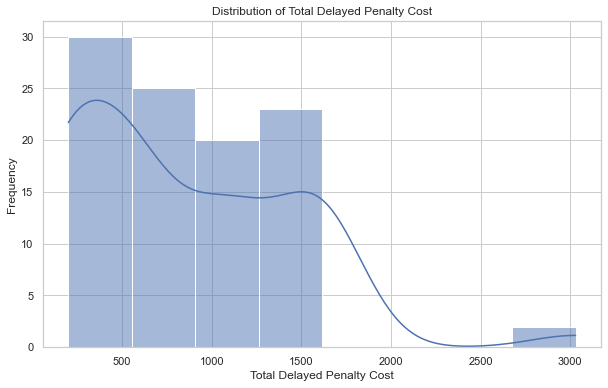

In [337]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(cost_records['Total Delay Penalty Cost'], kde=True)

plt.title('Distribution of Total Delayed Penalty Cost')
plt.xlabel('Total Delayed Penalty Cost')
plt.ylabel('Frequency')

plt.show()